# 2-colour imaging: RecB-Halo + Nucleoid (Sytox)

In [ ]:
from pyberries.data import DatasetPool, get_histogram
import seaborn.objects as so
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = (DatasetPool(path='./../../BACMMAN_datasets',
                    dsList=['240424_1', '240612_1', '240620_1',
                            '240717_3', '240904_1', '240904_2',
                            '240620_3', '240717_1', '240717_2',
                            '240717_4', '240904_3', '240904_4',
                            '240424_2', '240612_2', '240620_2'
                            ],
                    groups=['0 ng/ml', '0 ng/ml', '0 ng/ml',
                            '3 ng/ml', '3 ng/ml', '3 ng/ml',
                            '10 ng/ml', '10 ng/ml', '10 ng/ml',
                            '20 ng/ml', '20 ng/ml', '20 ng/ml',
                            '30 ng/ml', '30 ng/ml', '30 ng/ml'
                            ],
                    metadata='DateTime'
                    )
        .heatmap_metrics(object_name=['Nucleoid', 'RecB_spots'])
        .drop_duplicates(object_name='RecB_spots', subset=['Dataset', 'Position', 'TrackHeadIndices'])
        .assign(Time_min=lambda df: df.Time_min + 15)
        .bin_column(col='Time_min', binsize=15, binlabels='left')
        .assign(Group=lambda df: df.Group.astype('category').cat.set_categories(['0 ng/ml', '3 ng/ml', '10 ng/ml', '20 ng/ml', '30 ng/ml'], ordered=True))
        )

Dataset 240424_1 (group 0 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240612_1 (group 0 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240620_1 (group 0 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240717_3 (group 3 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240904_1 (group 3 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240904_2 (group 3 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240620_3 (group 10 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240717_1 (group 10 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240717_2 (group 10 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240717_4 (group 20 ng/ml): loaded o

## General statistics

Number of cells

In [2]:
display(data
        .Bacteria_large
        .query('Frame == 0')
        .agg({'Indices':'count'})
        )

Indices    24014
dtype: int64

Number of RecB spots

In [3]:
display(data
        .RecB_spots
        .agg({'Indices':'count'})
        )

Indices    79969
dtype: int64

Number of nucleoids

In [5]:
display(data
        .Nucleoid
        .query('Frame == 0')
        .agg({'Indices':'count'})
        )

Indices    31441
dtype: int64

## Nucleoid compaction

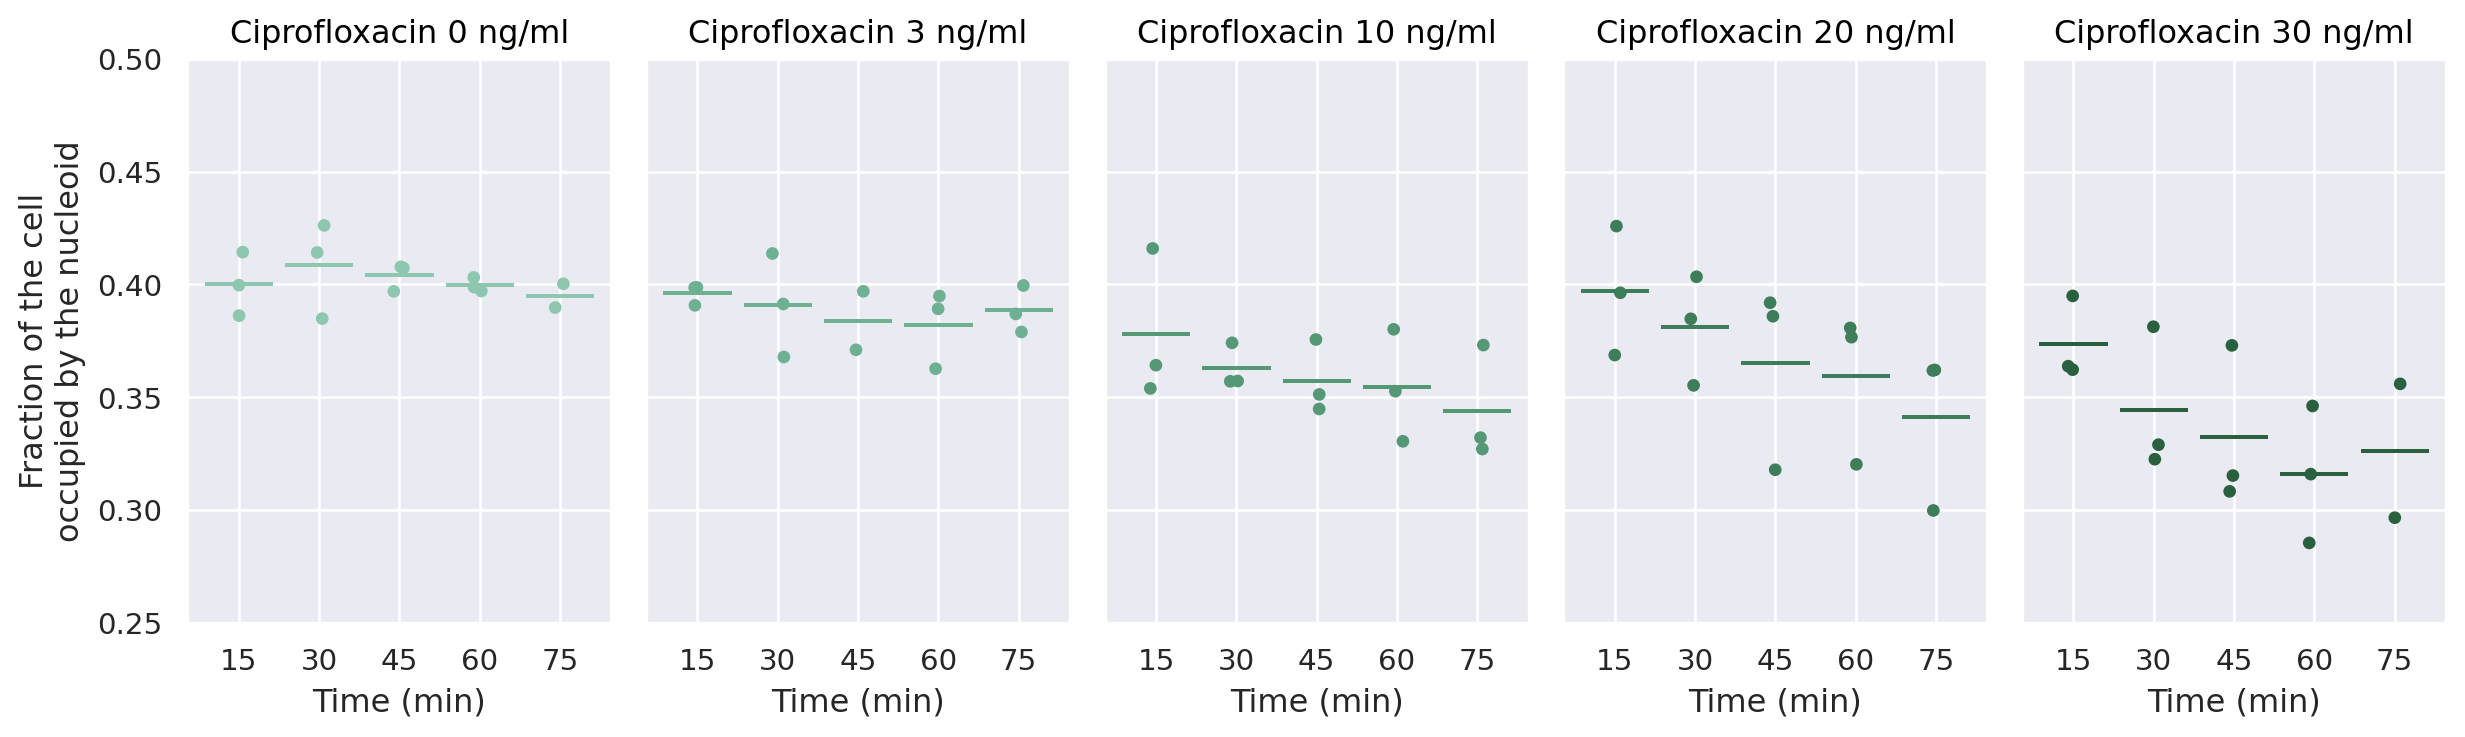

In [8]:
df = (data
      .add_from_child(object_name='Bacteria_large', child='Nucleoid', col='Nucleoid_size', agg='sum')
      .Bacteria_large
      .assign(frac_nucleoid=lambda df: df.Nucleoid_size / df.Area)
      .groupby(['Group', 'Dataset', 'Time_min_bin'], observed=True)
      .agg({'frac_nucleoid':'mean'})
      )

palette = sns.cubehelix_palette(n_colors=5, start=2, rot=.1, dark=.3, light=.7)

(
      so.Plot(df, x='Time_min_bin', y='frac_nucleoid', color='Group')
      .facet(col='Group')
      .layout(size=(13, 4))
      .add(so.Dash(), so.Agg(), legend=False)
      .add(so.Dots(fillalpha=1, pointsize=4), so.Jitter(), legend=False)
      .scale(color=palette, x=so.Continuous().tick(every=15))
      .label(x='Time (min)', y='Fraction of the cell\noccupied by the nucleoid', title='Ciprofloxacin {}'.format)
      .limit(y=(0.25, 0.5))
      .save(loc='/media/daniel/HDD Daniel/DanielThedie/Python/RecB_article/SI_Figures/Nucleoid_compaction.pdf', format='pdf', bbox_inches='tight')
)

## Nucleoid position

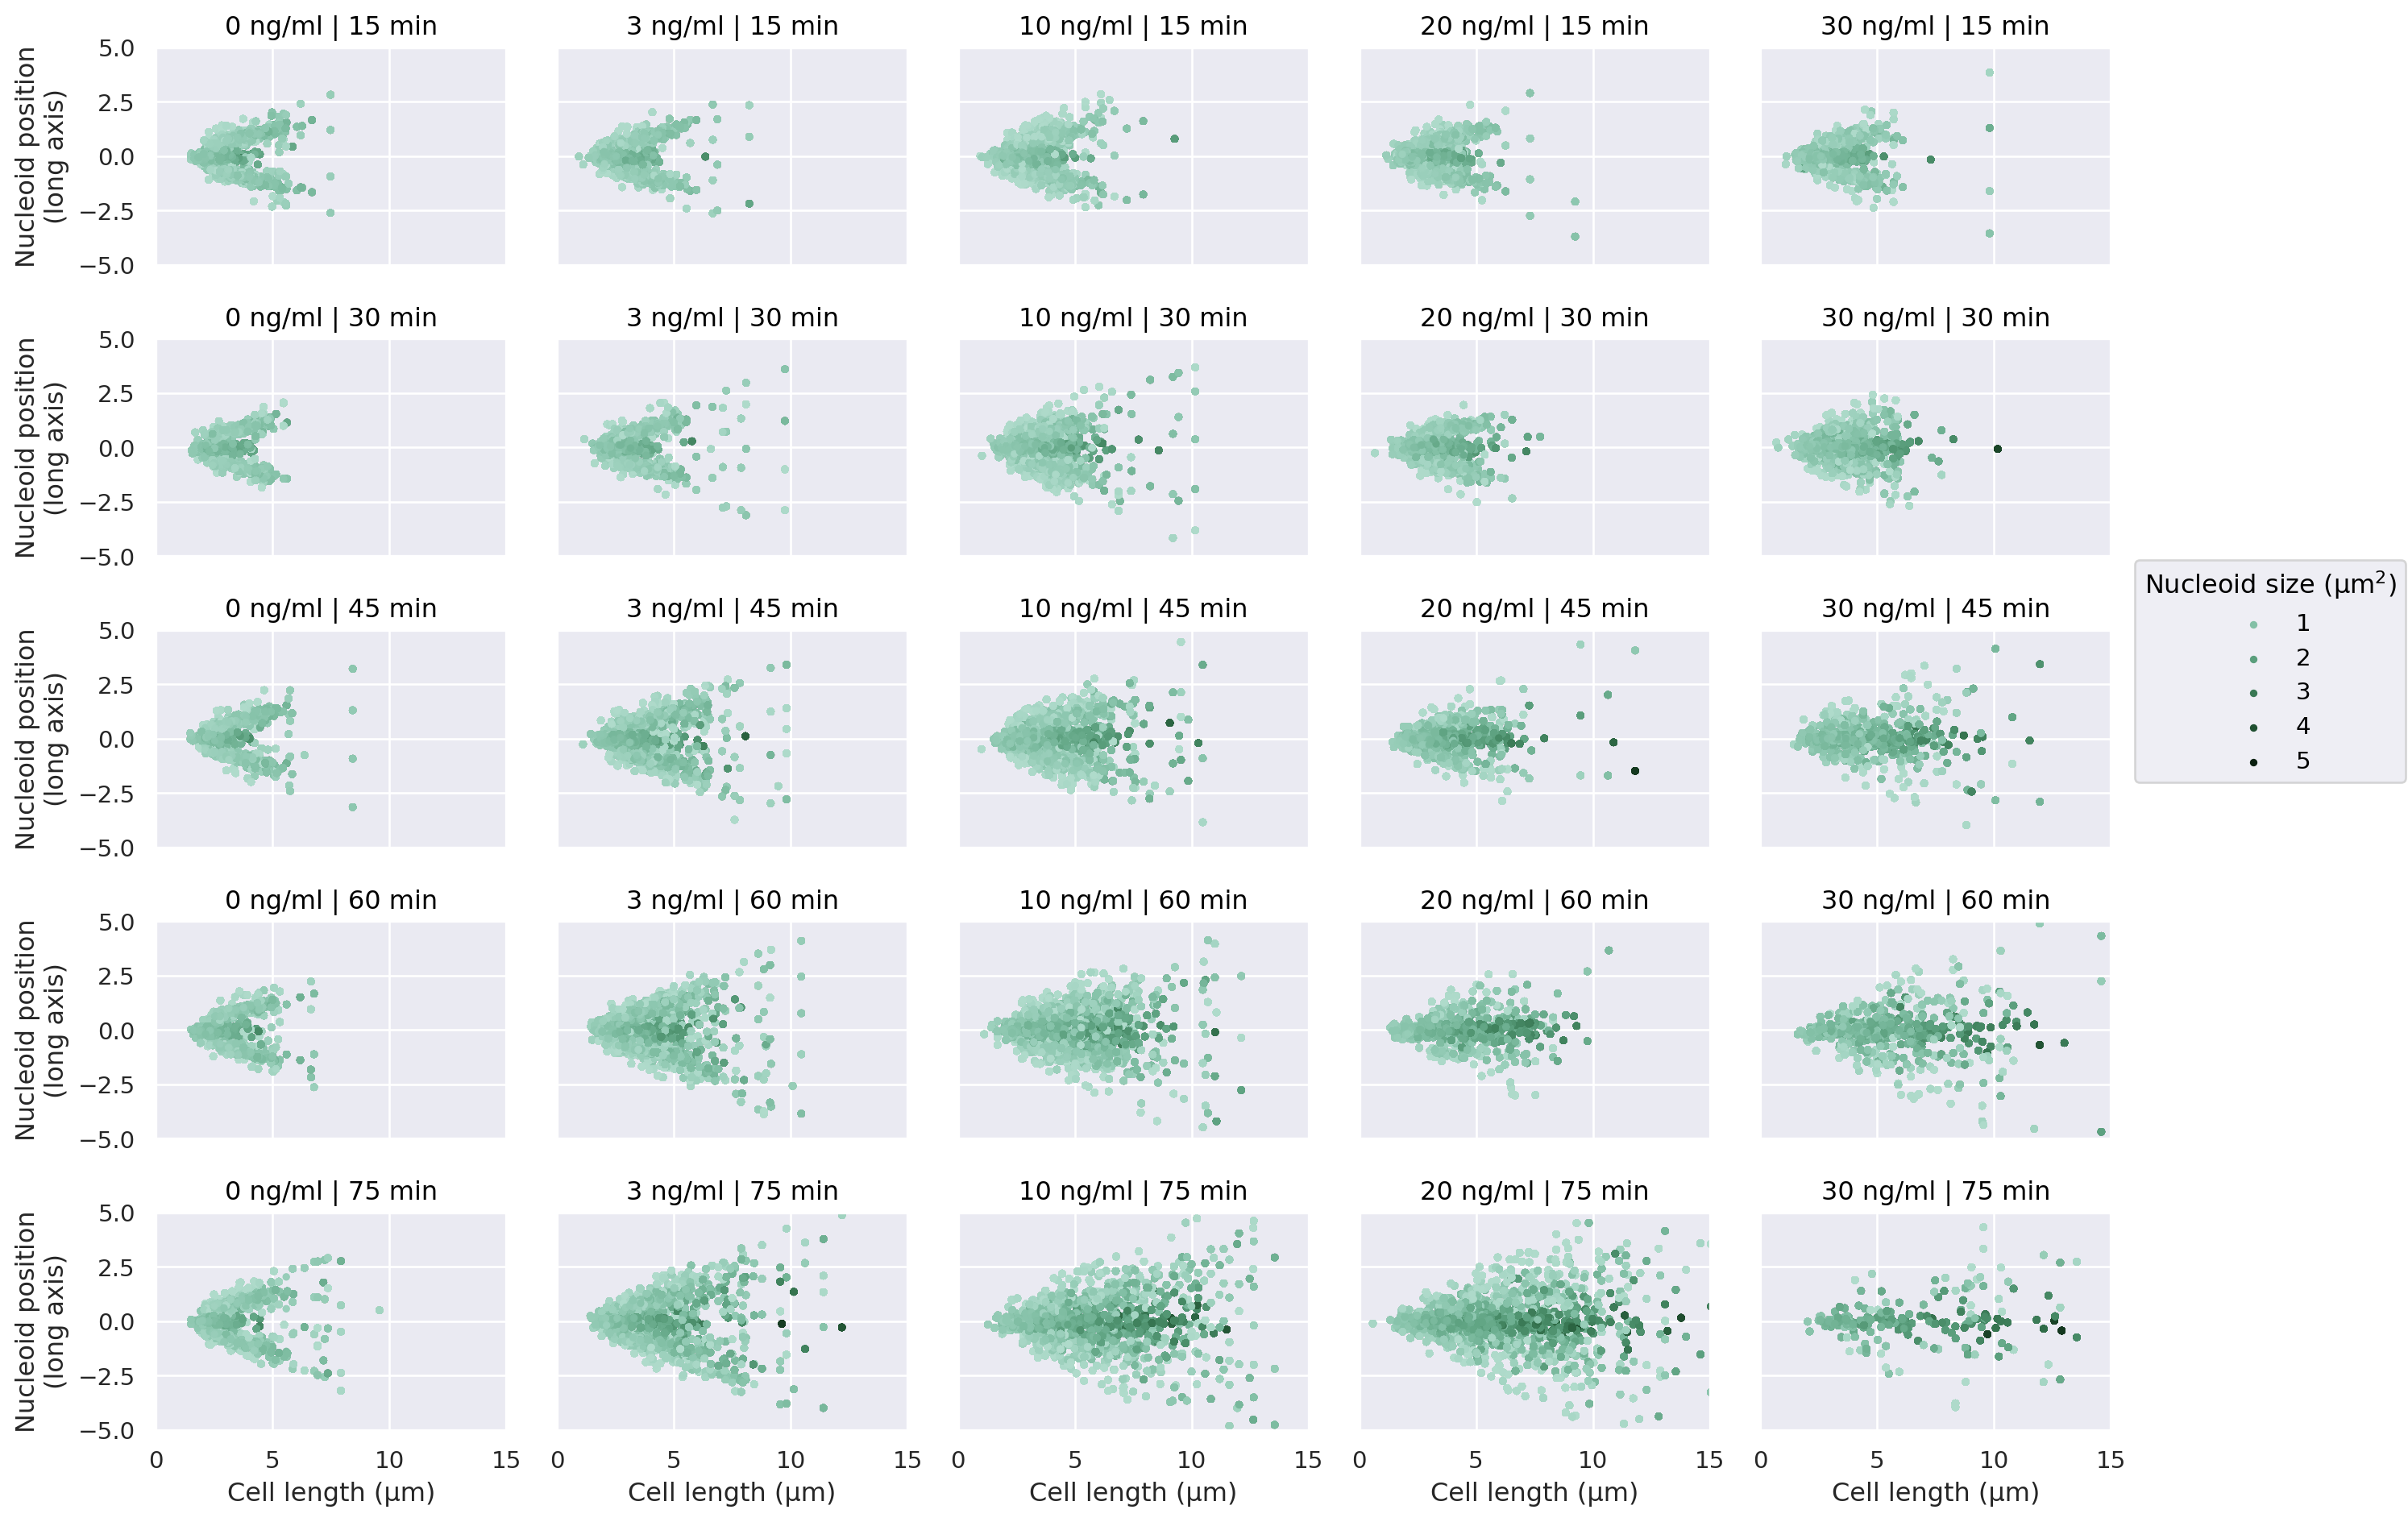

In [27]:
df = (data
      .Nucleoid
      .assign(Time_min_bin=lambda df: df.Time_min_bin.astype('int').astype('str') + ' min')
      )

palette = sns.cubehelix_palette(start=2, rot=.1, dark=0, light=.8, as_cmap=True)

(
    so.Plot(df, x='SpineLength', y='centerLongCoord', color='Nucleoid_size')
    .layout(size=(14,10))
    .facet(col='Group', row='Time_min_bin')
    .add(so.Dot(marker='o', pointsize=3))
    .limit(x=(0, 15), y=(-5, 5))
    .scale(color=so.Continuous(palette).tick(every=1))
    .label(x='Cell length (µm)', y='Nucleoid position\n(long axis)', color='Nucleoid size (µm$^2$)')
    .save(loc='/media/daniel/HDD Daniel/DanielThedie/Python/RecB_article/SI_Figures/Nucleoid_position.png', format='png', dpi=300, bbox_inches='tight')
)

In [4]:
df = (data
      .Bacteria_large
      .assign(no_nucleoid=lambda df: df.NucleoidCount.eq(0).astype('int')*100,
              )
      .groupby('Group', observed=True)
      .agg({'no_nucleoid':'mean'})
      .assign(no_nucleoid=lambda df: df.no_nucleoid.astype('int').astype('str') + '%')
      .rename(columns={'no_nucleoid':'Cells with no nucleoid'})
      )

display(df)

,Cells with no nucleoid
Group,
0 ng/ml,1%
3 ng/ml,1%
10 ng/ml,5%
20 ng/ml,0%
30 ng/ml,2%


## Nucleoid/RecB colocalisation

In [5]:
df = (data
      .RecB_spots
      .assign(spot_in_nucleoid=lambda df: df.ParentNucleoidIndices.notna().astype('int')*100,
              long_spot=lambda df: df.TrackLength.ge(5)
              )
      .query('long_spot == True')
      .groupby('Group', observed=True)
      .agg({'spot_in_nucleoid':'mean'})
      .assign(spot_in_nucleoid=lambda df: df.spot_in_nucleoid.astype('int').astype('str') + '%')
      .rename(columns={'spot_in_nucleoid':'DNA-bound RecB in a nucleoid'})
      )

display(df)

,DNA-bound RecB in a nucleoid
Group,
0 ng/ml,70%
3 ng/ml,72%
10 ng/ml,71%
20 ng/ml,83%
30 ng/ml,82%


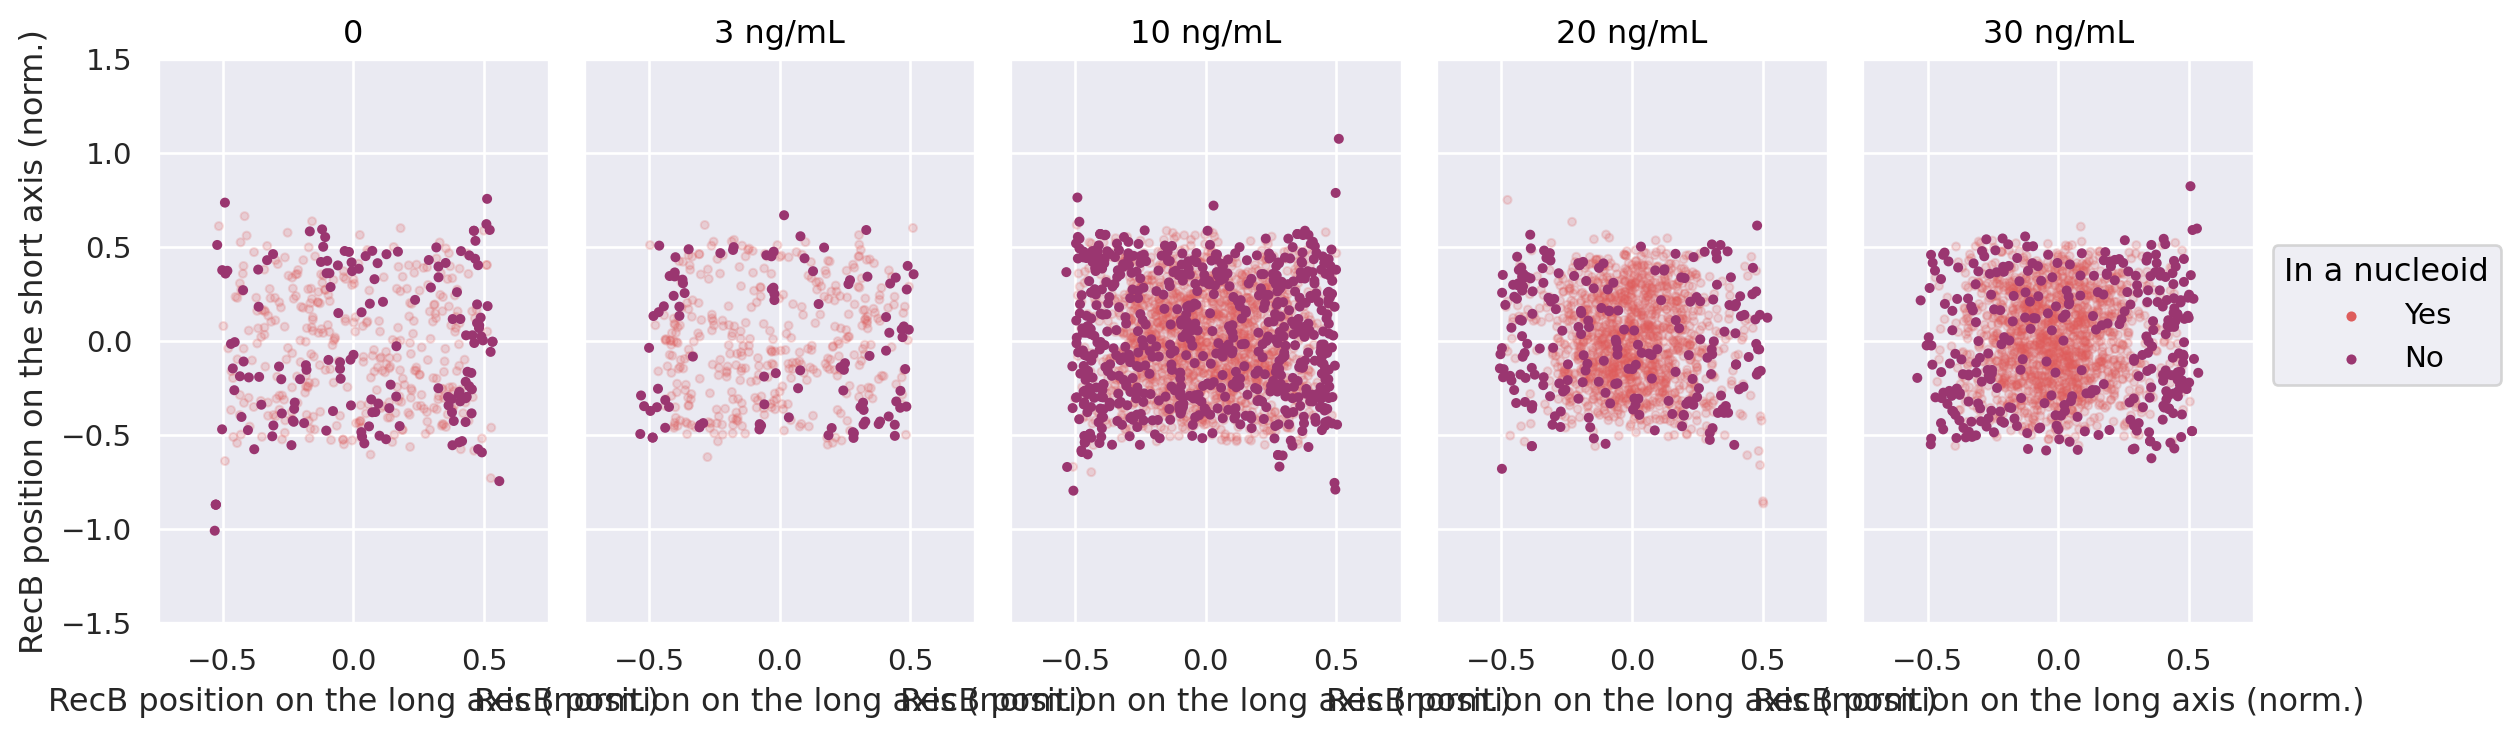

In [7]:
df = (data
      .apply_filters({'RecB_spots':'TrackLength >= 5'})
      .assign(object_name='RecB_spots', spot_in_nucleoid=lambda df: df.ParentNucleoidIndices.notna().astype('int'))
      .add_from_child(object_name='Bacteria_large', col='centerLongCoord', child='Nucleoid', agg='first', rename='nucleoid_pos')
      .add_from_child(object_name='Bacteria_large', col=['normLongCoord', 'normShortCoord', 'spot_in_nucleoid'], child='RecB_spots', agg='first', rename=['RecB_long', 'RecB_short', 'in_nucleoid'])
      .Bacteria_large
      .assign(in_nucleoid=lambda df: df.in_nucleoid.replace({0:'No', 1:'Yes'}))
      )

(
    so.Plot(df, x='RecB_long', y='RecB_short', color='in_nucleoid')
    .layout(size=(15,4))
    .facet(col='Group')
    .add(so.Dots(marker='.', alpha=.2, fillalpha=.2, pointsize=6), data=df.query('in_nucleoid == "Yes"'))
    .add(so.Dots(marker='.', alpha=1, fillalpha=1, pointsize=6), data=df.query('in_nucleoid == "No"'))
    .limit(x=(-.75, .75), y=(-1.5, 1.5))
    .scale(color='flare')
    .label(x='RecB position on the long axis (norm.)', y='RecB position on the short axis (norm.)', color='In a nucleoid')
)

Without normalisation to cell length:

/media/daniel/HDD Daniel/DanielThedie/Python/PyBerries/pyberries/data/DataFrame_util.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .pipe(lambda df: df.groupby(groupby, sort=False) if groupby else df)


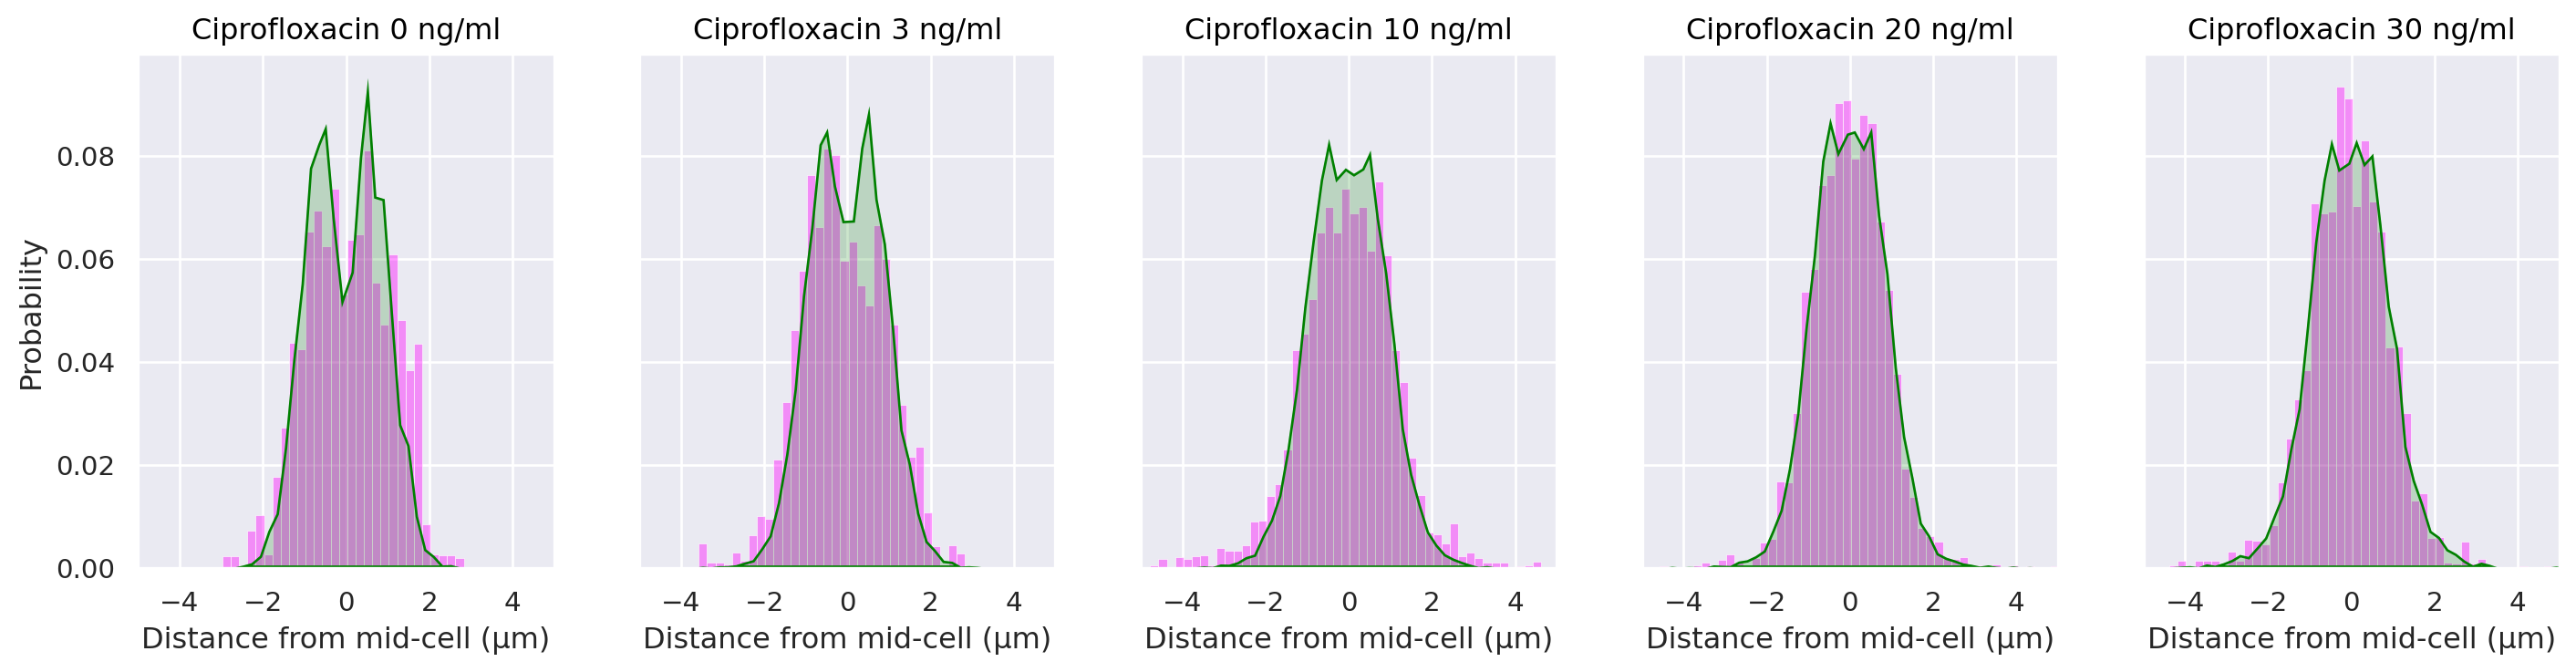

In [2]:
dx = 0.5

df = (pd.concat([data
                .add_from_parent(object_name='Nucleoid', col='NucleoidCount')
                .apply_filters({'Bacteria_large':'NucleoidCount > 0 and NucleoidCount <= 2'})
                .Nucleoid
                .dropna()
                .assign(LowerBound=lambda df: df.centerLongCoord - df.NucleoidLength/2,
                        nPoints=lambda df: round(df.NucleoidLength / dx).astype('int')
                        )
                .pipe(lambda df: df.loc[df.index.repeat(df.nPoints)])
                .reset_index(names='id')
                .assign(SubID=lambda df: df.groupby('id', observed=True)['id'].cumcount() +0.5,
                        Density=lambda df: df.LowerBound + df.SubID *dx,
                        Object='Nucleoid'
                        )
                [['Group', 'Dataset', 'Time_min_bin', 'Density', 'Object']],
                data
                .add_from_parent(object_name='RecB_spots', col='NucleoidCount')
                .apply_filters({'RecB_spots': 'TrackLength >= 5', 'Bacteria_large':'NucleoidCount > 0 and NucleoidCount <= 2'})
                .RecB_spots
                .assign(Object='RecB')
                .rename(columns={'centerLongCoord':'Density'})
                [['Group', 'Dataset', 'Time_min_bin', 'Density', 'Object']]
                ])
        .query('Time_min_bin < 90')
        .assign(Time_min_bin=lambda df: df.Time_min_bin.astype('int').astype('str') + ' min')
        )

hist = (get_histogram(df, col='Density', groupby=['Group', 'Time_min_bin', 'Object'], density=True, binsize=.2)
        .pipe(lambda df: pd.pivot_table(df, values='proportion', index=['Group', 'Time_min_bin', 'Density'], columns='Object'))
        .reset_index()
        )

(
    so.Plot(hist, x='Density')
    .facet(col='Group')
    .layout(size=(15,4))
    .add(so.Bars(color='magenta', alpha=.4), so.Agg(),  y='RecB')
    .add(so.Area(color='green'), so.Agg(), y='Nucleoid')
    .label(x='Distance from mid-cell (µm)', y='Probability', title='Ciprofloxacin {}'.format)
    .limit(x=(-5, 5), y=(0, None))
    .save(loc='/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/3_Nucleoid/RecB_Nucleoid_position_overlay.svg', format='svg', bbox_inches='tight')
)

/media/daniel/HDD Daniel/DanielThedie/Python/PyBerries/pyberries/data/DataFrame_util.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .pipe(lambda df: df.groupby(groupby, sort=False) if groupby else df)


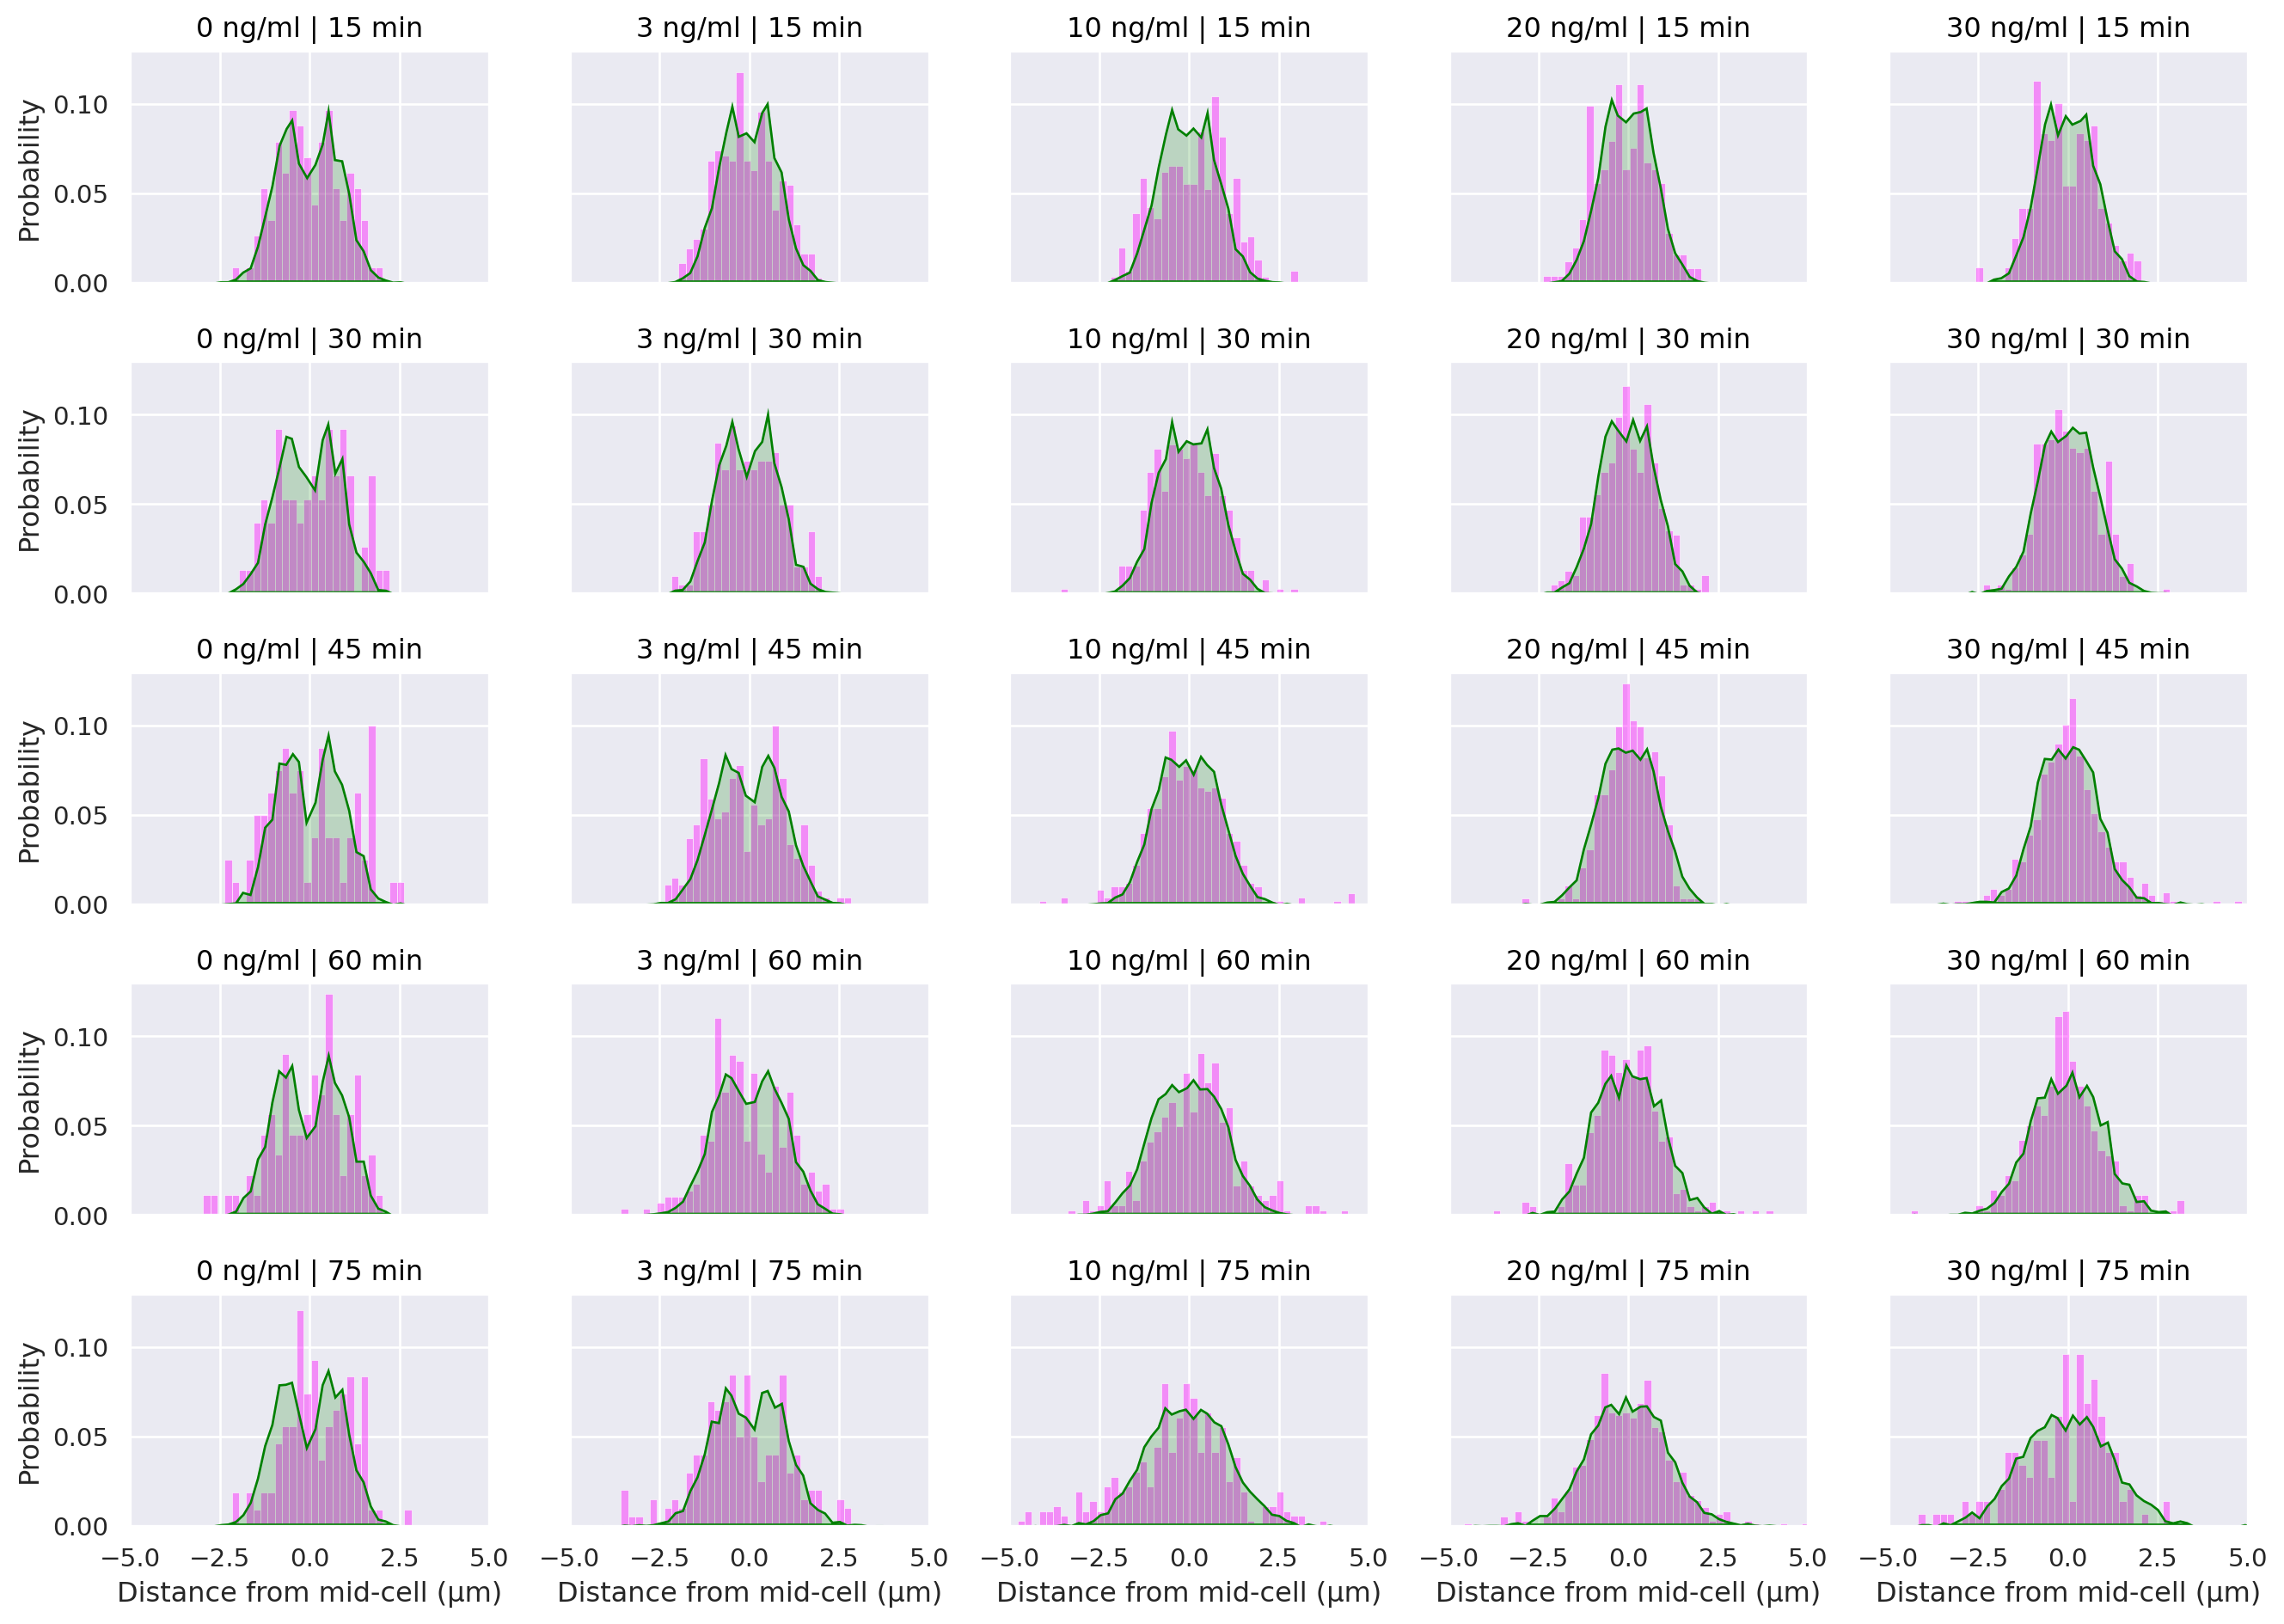

In [7]:
dx = 0.5

df = (pd.concat([data
                .add_from_parent(object_name='Nucleoid', col='NucleoidCount')
                .apply_filters({'Bacteria_large':'NucleoidCount > 0 and NucleoidCount <= 2'})
                .Nucleoid
                .dropna()
                .assign(LowerBound=lambda df: df.centerLongCoord - df.NucleoidLength/2,
                        nPoints=lambda df: round(df.NucleoidLength / dx).astype('int')
                        )
                .pipe(lambda df: df.loc[df.index.repeat(df.nPoints)])
                .reset_index(names='id')
                .assign(SubID=lambda df: df.groupby('id', observed=True)['id'].cumcount() +0.5,
                        Density=lambda df: df.LowerBound + df.SubID *dx,
                        Object='Nucleoid'
                        )
                [['Group', 'Dataset', 'Time_min_bin', 'Density', 'Object']],
                data
                .add_from_parent(object_name='RecB_spots', col='NucleoidCount')
                .apply_filters({'RecB_spots': 'TrackLength >= 5', 'Bacteria_large':'NucleoidCount > 0 and NucleoidCount <= 2'})
                .RecB_spots
                .assign(Object='RecB')
                .rename(columns={'centerLongCoord':'Density'})
                [['Group', 'Dataset', 'Time_min_bin', 'Density', 'Object']]
                ])
        .query('Time_min_bin < 90')
        .assign(Time_min_bin=lambda df: df.Time_min_bin.astype('int').astype('str') + ' min')
        )

hist = (get_histogram(df, col='Density', groupby=['Group', 'Time_min_bin', 'Object'], density=True, binsize=.2)
        .pipe(lambda df: pd.pivot_table(df, values='proportion', index=['Group', 'Time_min_bin', 'Density'], columns='Object'))
        .reset_index()
        )

(
    so.Plot(hist, x='Density')
    .facet(row='Time_min_bin', col='Group')
    .layout(size=(14,10))
    .add(so.Bars(color='magenta', alpha=.4), so.Agg(),  y='RecB')
    .add(so.Area(color='green'), so.Agg(), y='Nucleoid')
    .label(x='Distance from mid-cell (µm)', y='Probability')
    .limit(x=(-5, 5), y=(0, None))
    .save(loc='/media/daniel/HDD Daniel/DanielThedie/Python/RecB_article/SI_Figures/RecB_Nucleoid_position_timepoints.pdf', format='pdf', bbox_inches='tight')
)